In [2]:
from scipy import signal
from scipy.stats import norm
import numpy as np

def preprocess_vibration_data(data, sampling_frequency, lpf):
    # Step 1: Band-pass filtering
    # Design a Butterworth band-pass filter from 0.1 Hz to the Nyquist frequency
    b, a = signal.butter(4, lpf / (sampling_frequency / 2))
    
    # Apply the filter to the data
    data_filtered = signal.lfilter(b, a, data)
    

    # Step 3: Signal conditioning
    # Subtract the mean and divide by the standard deviation
    conditioned_data = (data_filtered - np.mean(data_filtered)) / np.std(data_filtered)
    rms= np.sqrt(np.mean(np.square(conditioned_data)))
    return conditioned_data, rms

In [3]:


def apply_welch(sig, sr:int,nperseg:int,noverlap:int|None=None):
    if noverlap is None:
        noverlap = nperseg // 2
    f, Pxx_den = signal.welch(sig, sr, nperseg=nperseg, noverlap=noverlap)
    return f, Pxx_den


In [4]:
from scipy.signal import find_peaks
def introduce_anomaly(Pxx_den, f, freq_OI=30, shift=0.1):
    # Identifying the peaks

    
    Pxx = np.log10(Pxx_den)
    peak_indices = find_peaks(Pxx, prominence=0.05)[0]
    peaks_freqs = f[peak_indices]
    print(peaks_freqs)
    peak_powers = Pxx[peak_indices]

    # Finding the peak of interest
    modal_OI = np.argmin(np.abs(peaks_freqs - freq_OI))
    peak_power_OI = peak_powers[modal_OI]
    print(f[modal_OI])



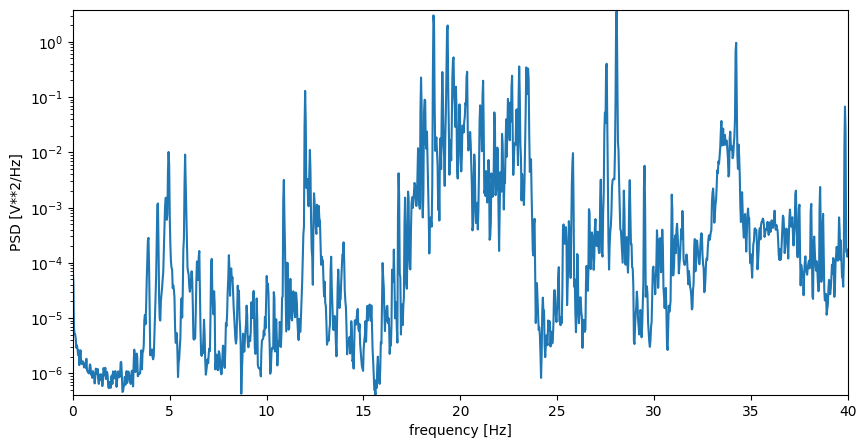

In [6]:
import sys
from pathlib import Path
from datetime import datetime, timedelta
import logging
import h5py
from VOOD.data import data_loader as dl
from config import settings
import numpy as np
from tqdm import tqdm
from multiprocessing import Pool, Manager
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import eigh
from scipy.signal import find_peaks


EPS = sys.float_info.epsilon
psd_frame = timedelta(minutes=10)
start_time = datetime(2022, 3, 30, 0, 0, 0)
end_time = datetime(2022, 6, 25, 0, 0, 0)
dt = datetime(2022, 4, 21, 0, 0, 0)
psd_frame = timedelta(minutes=5)
psd_step = timedelta(minutes=8)
sensor = dl.Sensor(name='ACC', location='MO04', data_type='TDD', format='.tdms')
loader = dl.DataLoader(sensor=sensor)
data = loader.get_data(dt, dt + psd_frame)
time = np.arange(0, len(data['ACC3_Z'])) / 250

sig = data['ACC3_Z']
filtered_data, time = preprocess_vibration_data(sig, 250,50)
f, Pxx_den = apply_welch(filtered_data, 250, 8192)
fig,ax=plt.subplots(figsize=(10, 5))
ax.plot(f, Pxx_den)
ax.set_xlabel('frequency [Hz]')
ax.set_ylabel('PSD [V**2/Hz]')
ax.set_xlim([0, 40])
ax.set_ylim(Pxx_den[0:int(40/(200/8192))].min(), Pxx_den[0:int(40/(200/8192))].max())
ax.set_yscale('log')


In [363]:
import numpy as np
from scipy.signal import find_peaks
from scipy.interpolate import interp1d

def simulate_anomaly(Pxx_den, f, mode_of_interest, shift, window):
    new_mode = mode_of_interest + shift
    window = int(window / (f[1] - f[0]) / 2)
    arg_NM = np.argmin(np.abs(f - new_mode))
    arg_MOI = np.argmin(np.abs(f - mode_of_interest))
    Pxx_den_a = Pxx_den.copy()
    empty_region = Pxx_den_a[arg_MOI - window : arg_MOI + window]
    x = np.arange(len(empty_region))
    f_interp = interp1d(x, empty_region, kind='cubic')
    interpolated_values = f_interp(np.linspace(0, len(empty_region)-1, window*2))
    Pxx_den_a[arg_MOI - window : arg_MOI + window] = interpolated_values
    Pxx_den_a[arg_NM - window : arg_NM + window] = Pxx_den[arg_MOI - window : arg_MOI + window]
    return Pxx_den_a


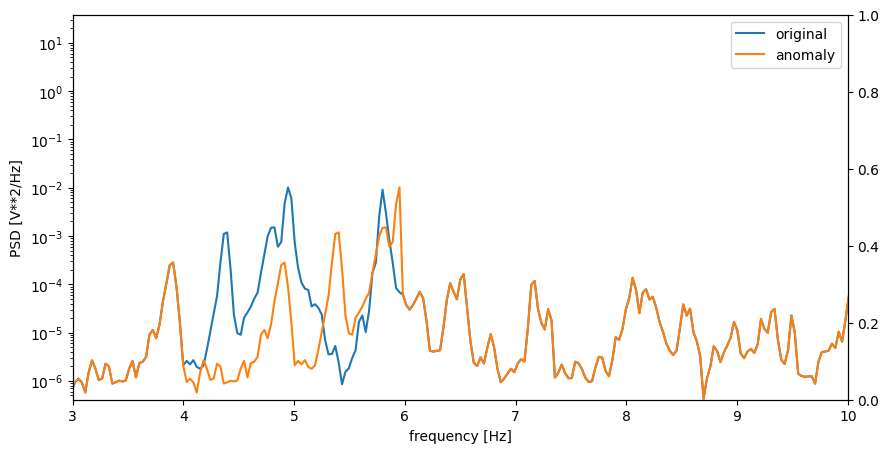

In [367]:
Pxx_den_a=simulate_anomaly(Pxx_den, f,4,1,2)

fig,ax=plt.subplots(figsize=(10, 5))
ax.plot(f, Pxx_den, label='original')
ax.plot(f, Pxx_den_a, label='anomaly')
ax1 = ax.twinx()

ax.set_xlabel('frequency [Hz]')
ax.set_ylabel('PSD [V**2/Hz]')
ax.set_xlim([3, 10])
ax.set_ylim(Pxx_den[0:int(40/(200/8192))].min(), Pxx_den[0:int(40/(200/8192))].max()*10)
ax.set_yscale('log')
ax.legend()

In [85]:
std

1.0446843765243374e-05

(25.0, 40.0)

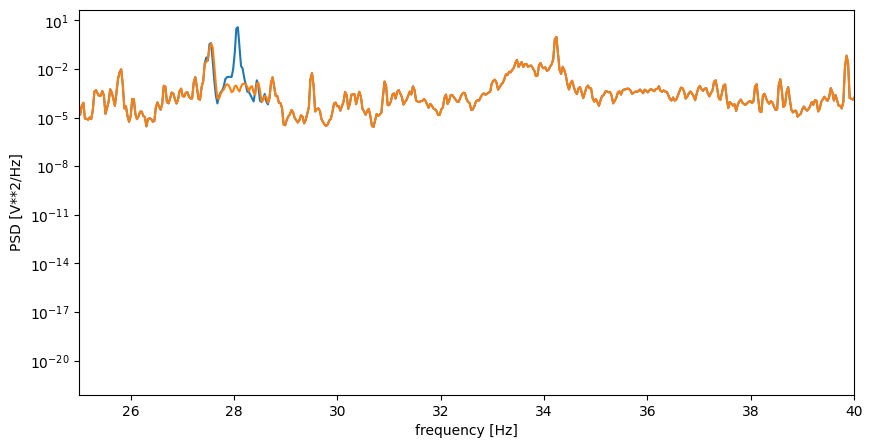

In [145]:
from tsaug import TimeWarp, Crop, Quantize, Drift, Reverse, AddNoise, Convolve
modificator = Drift(20)
Pxx_den_a = Pxx_den.copy()
min = np.median(Pxx_den_a[index_MOI-30:index_MOI+30])
std= np.subtract(*np.percentile(Pxx_den_a[index_MOI-10:index_MOI+10],[90,10])) *min
Pxx_den_a[index_MOI-10:index_MOI+10] = (np.random.normal(size=20,loc=min, scale=std))
Pxx_den_a[index_MOI-20:index_MOI+20] = np.convolve(Pxx_den_a[index_MOI-20:index_MOI+20], np.hanning(2)+1/2, mode='same')
fig,ax=plt.subplots(figsize=(10, 5))
ax.plot(f, Pxx_den, label='original')

ax.plot(f, Pxx_den_a, label='anomaly')
ax.set_yscale('log')
ax.set_xlabel('frequency [Hz]')
ax.set_ylabel('PSD [V**2/Hz]')
ax.set_xlim([25, 40])



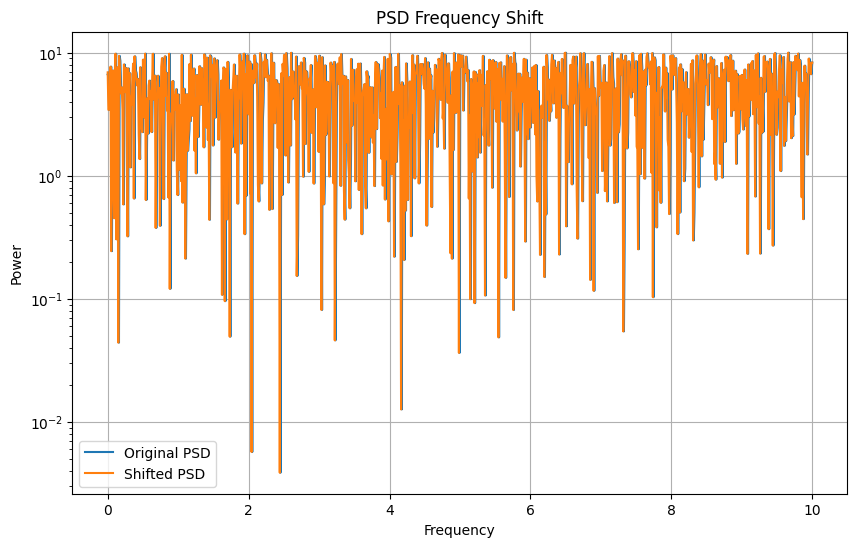

In [147]:
import numpy as np

import matplotlib.pyplot as plt

def shift_psd(psd, f_original, f_shift):
    # Calculate the frequency shift value
    delta_f = f_shift - f_original

    # Copy the original PSD
    shifted_psd = psd.copy()

    # Shift the frequency components
    num_freqs = len(shifted_psd)
    frequencies = np.arange(num_freqs)
    shifted_frequencies = frequencies + delta_f

    # Interpolate the power values to the shifted frequencies
    shifted_psd = np.interp(shifted_frequencies, frequencies, shifted_psd)

    return shifted_psd

# Generate a sample PSD
num_freqs = 1000
frequencies = np.linspace(0, 10, num_freqs)
psd = np.random.rand(num_freqs) * 10

# Define the original and shifted frequencies
f_original = 3.5
f_shift = 4.5

# Simulate the frequency shift
shifted_psd = shift_psd(psd, f_original, f_shift)

# Plot the original and shifted PSDs
plt.figure(figsize=(10, 6))
plt.plot(frequencies, psd, label='Original PSD')
plt.plot(frequencies, shifted_psd, label='Shifted PSD')
plt.yscale('log')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.title('PSD Frequency Shift')
plt.legend()
plt.grid(True)
plt.show()
